Shape train: (692500, 12)
Shape test : (296786, 12)
Accuracy en validación: 0.3925
Accuracy CV: 0.3910 (±0.0013)
Primeras filas del archivo submission:
       ID RENDIMIENTO_GLOBAL
0  550236               alto
1   98545         medio-alto
2  499179               alto
3  782980               bajo
4  785185         medio-bajo


C:\Users\gjcar\AppData\Local\Temp\ipykernel_25796\124540137.py:119: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.grid(); plt.tight_layout()


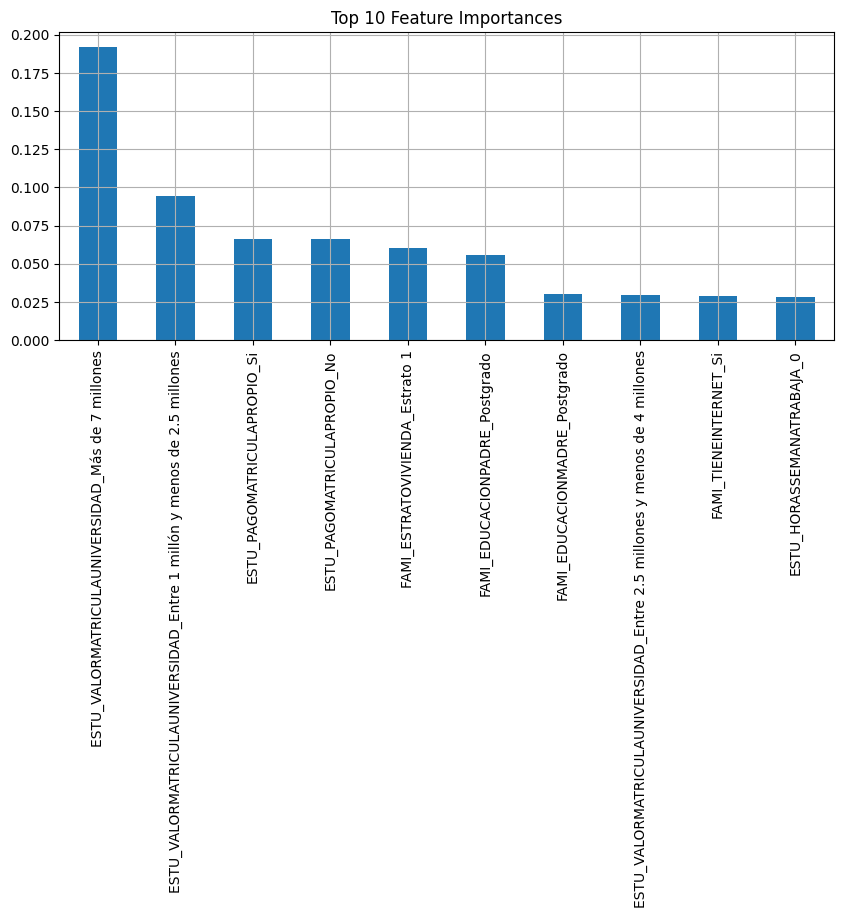

In [3]:
# =============================================
# 1. Librerías
# =============================================
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# =============================================
# 2. Cargar datos
# =============================================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Shape train:", train.shape)
print("Shape test :", test.shape)

# =============================================
# 3. Selección de variables
# =============================================
cols = [
    'ESTU_VALORMATRICULAUNIVERSIDAD',
    'FAMI_ESTRATOVIVIENDA',
    'FAMI_TIENEINTERNET',
    'FAMI_EDUCACIONPADRE',
    'FAMI_EDUCACIONMADRE',
    'ESTU_HORASSEMANATRABAJA',
    'ESTU_PAGOMATRICULAPROPIO',
    'ESTU_PRGM_DEPARTAMENTO'
]


train = train[['ID'] + cols + ['RENDIMIENTO_GLOBAL']]
test = test[['ID'] + cols]

# =============================================
# 4. Imputación de valores faltantes
# =============================================
for col in cols:
    modo = train[col].mode()[0]  # valor más frecuente
    train[col] = train[col].fillna(modo)
    test[col] = test[col].fillna(modo)

# =============================================
# 5. One-hot encoding
# =============================================
def one_hot(df, col):
    dummies = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df.drop(columns=[col]), dummies], axis=1)
    return df

for col in cols:
    train = one_hot(train, col)
    test = one_hot(test, col)

# Alinear columnas del test con el train
test = test.reindex(columns=train.drop(columns=['RENDIMIENTO_GLOBAL']).columns, fill_value=0)

# =============================================
# 6. Codificación de la variable objetivo
# =============================================
mapa = {'bajo':0, 'medio-bajo':1, 'medio-alto':2, 'alto':3}
inv_mapa = {v:k for k,v in mapa.items()}

y = train['RENDIMIENTO_GLOBAL'].map(mapa)
X = train.drop(columns=['RENDIMIENTO_GLOBAL'])

# =============================================
# 7. División para validación y entrenamiento
# =============================================
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.3, random_state=42)

# =============================================
# 8. Entrenamiento del modelo
# =============================================
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(Xtrain, ytrain)

# =============================================
# 9. Evaluación con accuracy
# =============================================
yval_pred = clf.predict(Xval)
acc = accuracy_score(yval, yval_pred)
print(f"Accuracy en validación: {acc:.4f}")

# Validación cruzada
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"Accuracy CV: {scores.mean():.4f} (±{scores.std():.4f})")

# =============================================
# 10. Entrenamiento final y predicción sobre test
# =============================================
clf.fit(X, y)
y_test_pred = clf.predict(test)

# =============================================
# 11. Crear archivo de submission
# =============================================
submission = pd.DataFrame({
    'ID': test['ID'],
    'RENDIMIENTO_GLOBAL': pd.Series(y_test_pred).map(inv_mapa)
})

submission.to_csv("submission.csv", index=False)
print("Primeras filas del archivo submission:")
print(submission.head())

# =============================================
# 12. Visualización de importancia de variables
# =============================================
importances = clf.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

top_n = 10  # número de variables más importantes a mostrar
feat_imp.head(top_n).plot(kind='bar', figsize=(10,4), title=f"Top {top_n} Feature Importances")
plt.grid(); plt.tight_layout()